In [32]:
import multidms
import pickle

In [33]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [34]:
# import pickle
# import multidms
import os
from functools import reduce

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import seaborn as sns
%matplotlib inline

In [35]:
# plt.rcParams.keys()

In [36]:
rc_kwargs = {
    'legend.frameon': False,
    "font.size" : 11,
    "font.weight" : "normal"
}

plt.rcParams.update(**rc_kwargs)

In [37]:
OUTDIR = "../results/manuscript_figures/"
if not os.path.exists(OUTDIR): os.mkdir(OUTDIR)

In [38]:
func_score_df = pd.read_csv("../data/prepped_func_scores_rep.csv").fillna("")

In [39]:
func_score_df

,func_score,aa_substitutions,condition,replicate
0,0.4616,N87T L517F T1006A,Delta,1
1,1.5096,D80L,Delta,1
2,-0.7202,A1026V D1168Y,Delta,1
3,1.1890,G75W K1154E,Delta,1
4,-1.2116,T307S S803L A893V,Delta,1
...,...,...,...,...
689428,-3.5000,K182R N405L S408* T941S D1163Y,Omicron_BA2,2
689429,-0.7129,P82S S112T D138T K1038N,Omicron_BA2,2
689430,-0.8500,L179P A222T G261H N405D,Omicron_BA2,2
689431,-2.3933,S27F G413E,Omicron_BA2,2


In [40]:
model_set = "../results/ridge_ch_30K/"
models = pickle.load(open(f"{model_set}/models.pkl", "rb"))
models.head()

,dataset,δ_huber,λ_lasso_shift,λ_ridge_beta,λ_ridge_shift,λ_ridge_gamma,λ_ridge_ch,data_idx,epistatic_model,output_activation,...,init_C_ref,warmup_beta,tol,num_training_steps,iterations_per_step,save_model_at,PRNGKey,step_loss,model_30000,replicate
0,<multidms.data.MultiDmsData object at 0x7fc420...,1,0,0,0,0.001,0.001,0,Sigmoid,Softplus,...,0.0,False,0.0001,30,1000,[30000],0,"[0.9457752724757239, 0.8002926034800666, 0.740...",<multidms.model.MultiDmsModel object at 0x7fc5...,0
1,<multidms.data.MultiDmsData object at 0x7fc311...,1,0,0,0,0.001,0.001,0,Sigmoid,Softplus,...,0.0,False,0.0001,30,1000,[30000],0,"[0.9400713589182407, 0.7854160730979735, 0.717...",<multidms.model.MultiDmsModel object at 0x7fc2...,1
2,<multidms.data.MultiDmsData object at 0x7fc420...,1,0.000001,0,0,0.001,0.001,0,Sigmoid,Softplus,...,0.0,False,0.0001,30,1000,[30000],0,"[0.9451376913088765, 0.8007392249549228, 0.739...",<multidms.model.MultiDmsModel object at 0x7fc2...,0
3,<multidms.data.MultiDmsData object at 0x7fc311...,1,0.000001,0,0,0.001,0.001,0,Sigmoid,Softplus,...,0.0,False,0.0001,30,1000,[30000],0,"[0.9410402097392394, 0.7858163889446297, 0.720...",<multidms.model.MultiDmsModel object at 0x7fc2...,1
4,<multidms.data.MultiDmsData object at 0x7fc420...,1,0.00001,0,0,0.001,0.001,0,Sigmoid,Softplus,...,0.0,False,0.0001,30,1000,[30000],0,"[0.9611385623566833, 0.8140179139439288, 0.756...",<multidms.model.MultiDmsModel object at 0x7fc2...,0


## Barcodes

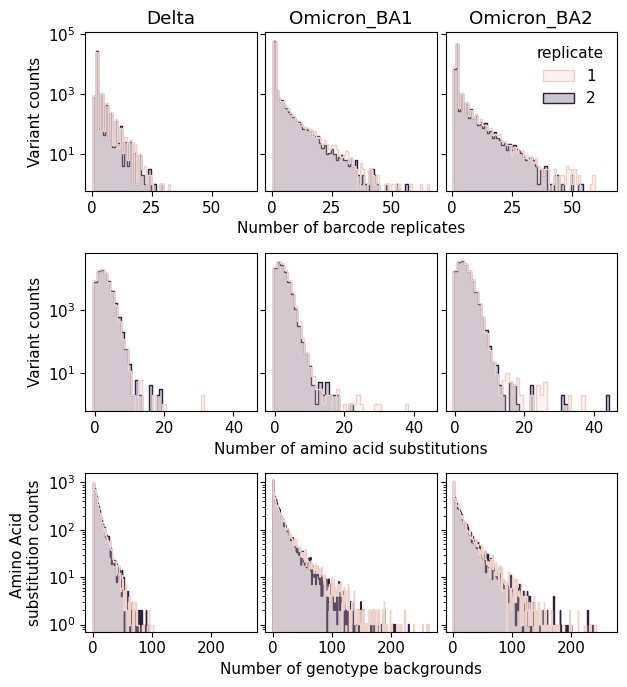

In [174]:
saveas = f"raw_data_summary_barcodes_backgrounds_hist"

fig, ax = plt.subplots(3,3, sharex="row", sharey="row", figsize=[6.4, 7])

row = 0
for col, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    iter_ax = ax[row, col]
    vc = condition_df.value_counts(["aa_substitutions", "replicate"]).reset_index()
    wt_vc = vc.query("aa_substitutions == ''")
    non_wt_vc = vc.query("aa_substitutions != ''")
    non_wt_vc = non_wt_vc.assign(num_barcodes = non_wt_vc['count'].astype('category'))
    sns.histplot(non_wt_vc, x="num_barcodes", ax=iter_ax, hue="replicate", element="step") #, discrete=True)
    iter_ax.set_yscale('log')
    if col != 2: 
        iter_ax.get_legend().remove()
    else:
        iter_ax.get_legend()
        
    xlabel = "Number of barcode replicates" if col == 1 else ""
    ylabel = "Variant counts" if col == 0 else ""
    iter_ax.set_ylabel(ylabel)
    iter_ax.set_xlabel(xlabel)
    iter_ax.set_title(condition)


row = 1
for col, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    iter_ax = ax[row, col]
    df = condition_df.assign(
        num_muts = [
            len(aa_subs.split())
            for aa_subs in condition_df.aa_substitutions
        ]
    )
    
    df = df.assign(num_muts = df['num_muts'].astype('category'))
    
    sns.histplot(df, x="num_muts", ax=iter_ax, hue="replicate", element="step") #, discrete=True)
    iter_ax.set_yscale('log')
    iter_ax.get_legend().remove()
    xscale = "Number of amino acid substitutions" if col == 1 else ""
    iter_ax.set_xlabel(xscale)
    ylabel = "Variant counts" if col == 0 else ""
    iter_ax.set_ylabel(ylabel)
    
row = 2
collapsed_bc_df = func_score_df.groupby(
    ["replicate", "condition", "aa_substitutions"]
).aggregate("mean").reset_index()
for col, (condition, condition_df) in enumerate(collapsed_bc_df.groupby("condition")):
    iter_ax = ax[row, col]
    df = pd.DataFrame()
    for rep, rep_df in condition_df.groupby("replicate"):
        
        times_seen = (
            rep_df["aa_substitutions"].str.split().explode().value_counts()
        )
        if (times_seen == times_seen.astype(int)).all():
            times_seen = times_seen.astype(int)
        times_seen = pd.DataFrame(times_seen)
        times_seen.index.name = f"mutation"
        df = pd.concat([df, times_seen.assign(replicate=rep).reset_index()])

    df = df.assign(num_backgrounds = df['count'].astype('category'))
    
    sns.histplot(df, x="num_backgrounds", ax=iter_ax, hue="replicate", element="step") #, discrete=True)
    iter_ax.set_yscale('log')
    iter_ax.get_legend().remove()
    xscale = "Number of genotype backgrounds" if col == 1 else ""
    iter_ax.set_xlabel(xscale)
    ylabel = "Amino Acid \nsubstitution counts" if col == 0 else ""
    iter_ax.set_ylabel(ylabel)

plt.tight_layout()
fig.subplots_adjust(wspace=0.05)
fig.savefig(f"{OUTDIR}/{saveas}.pdf")
fig.savefig(f"{OUTDIR}/{saveas}.png")
plt.show()

## Correlation of Replicate Functional Scores

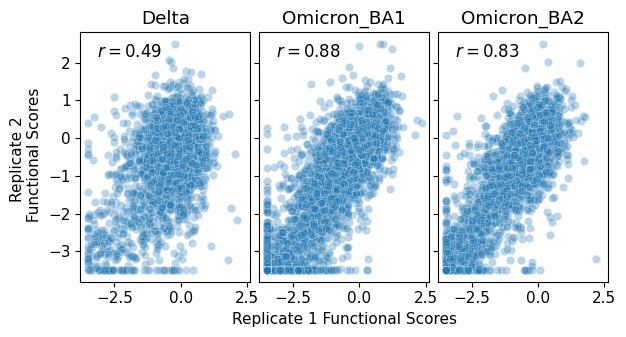

In [166]:
saveas = "replicate_functional_score_correlation_scatter"

fig, ax = plt.subplots(1,3, sharex="row", sharey="row", figsize=[6.4, 3.5])
collapsed_bc_df = func_score_df.groupby(
    ["replicate", "condition", "aa_substitutions"]
).aggregate("mean").reset_index()
for col, (condition, condition_df) in enumerate(collapsed_bc_df.groupby("condition")):
    iter_ax = ax[col]
    df = reduce(
        lambda left, right: pd.merge(
            left, right, left_index=True, right_index=True, how="inner"
        ),
        [
            rep_df.rename({"func_score":f"rep_{rep}_func_score"}, axis=1).set_index("aa_substitutions")
            for rep, rep_df in condition_df.groupby("replicate") 
        ],
    )
    sns.scatterplot(
        df, 
        x="rep_1_func_score", 
        y="rep_2_func_score", 
        ax =iter_ax,
        alpha=0.3
    )
    corr = pearsonr(df["rep_1_func_score"], df["rep_2_func_score"])[0]
    iter_ax.annotate(
        f"$r = {corr:.2f}$", 
        (0.1, 0.9), 
        xycoords="axes fraction", 
        fontsize=12
    )
    iter_ax.set_title(condition)

ax[0].set_xlabel("")
ax[0].set_ylabel("Replicate 2 \n Functional Scores")

ax[1].set_xlabel("Replicate 1 Functional Scores")
ax[2].set_xlabel("")

# fig.suptitle("Variant Functional Score \nReplicate Correlation")
plt.tight_layout()
fig.subplots_adjust(wspace=0.05)
fig.savefig(f"{OUTDIR}/{saveas}.pdf")
fig.savefig(f"{OUTDIR}/{saveas}.png")
plt.show()

## Convergence Analysis

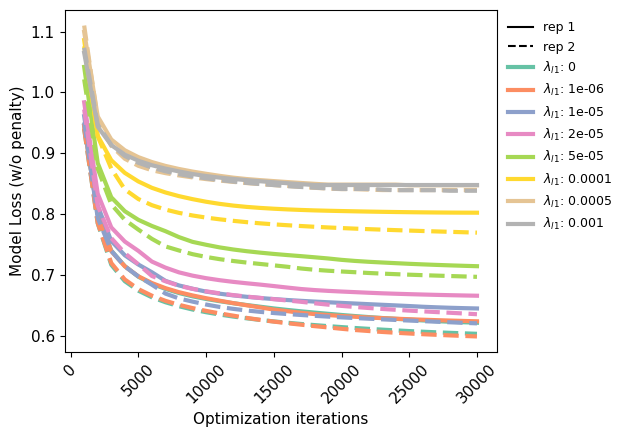

In [159]:
saveas="convergence_all_lasso_lines"
cmap=plt.get_cmap("Set2")


fig, ax = plt.subplots(1,figsize=[6.4,4.5])
color_idx = -1
for i, (model, model_row) in enumerate(models.iterrows()):
    if i%2 == 0: color_idx += 1

    ax.plot(
        [1000 * (s+1) for s in range(len(model_row.step_loss))],
        model_row.step_loss,
        c=cmap.colors[color_idx],
        lw=3,
        linestyle="-" if model_row.replicate == 0 else "--",
        label=f"rep: {model_row.replicate} λ: {model_row.λ_lasso_shift}"
    )
ax.set_xticks(ax.get_xticks()[1:-1], ax.get_xticklabels()[1:-1], rotation=45, ha='center')
ax.set_ylabel("Model Loss (w/o penalty)")
ax.set_xlabel("Optimization iterations")

black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
lasso_color_handles = [
    mlines.Line2D(
        [], [], 
        color=color, 
        linestyle='-',
        markersize=5,
        linewidth=3,
        label="$\lambda_{l1}$: "+str(lasso)
    )
    for lasso, color in zip(models.λ_lasso_shift.unique(), cmap.colors)
]

elements = [black_line, black_dashed] + lasso_color_handles
ax.legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)


# fig.suptitle("Replicate Fit Convergence")
plt.tight_layout()
fig.savefig(f"{OUTDIR}/{saveas}.pdf")
fig.savefig(f"{OUTDIR}/{saveas}.png")
plt.show()

## Shrinkage Analysis

In [130]:
import jax
from collections import defaultdict

In [131]:
times_seen_threshold = 3
model_name = "model_30000"

In [132]:
tall_mut_df = pd.DataFrame()
for replicate, rep_models in models.groupby("replicate"):
    fit_dict = {f"l_{float(row.λ_lasso_shift)}":row[model_name] for _, row in rep_models.iterrows()}
    
    
    mut_df = multidms.utils.combine_replicate_muts(
        fit_dict, 
        times_seen_threshold=times_seen_threshold, 
        how="outer"
    )


    mut_df = pd.melt(
        mut_df.reset_index(), 
        id_vars=["mutation"],
        value_vars=[
            col for col in mut_df.columns 
            if "_S_" in col and "avg" not in col
        ],
        value_name="S"
    )
    mut_df = mut_df.assign(
        λ_lasso=[ 
            v.split("_")[1]
            for v in mut_df.variable
        ],
        sense=[
            "Nonsense" if "*" in mut else "Missense"
            for mut in mut_df.mutation
        ],
        condition=[
            "_".join(v.split("_")[3:])
            for v in mut_df.variable
        ],
        replicate=replicate
    )
    
    mut_df.drop("variable", axis=1, inplace=True)
    tall_mut_df = pd.concat([tall_mut_df, mut_df])
    
tall_mut_df

,mutation,S,λ_lasso,sense,condition,replicate
0,M1I,0.365254,0.0,Missense,Delta,0
1,F2L,-0.133367,0.0,Missense,Delta,0
2,F2S,0.186726,0.0,Missense,Delta,0
3,V3A,-0.092486,0.0,Missense,Delta,0
4,V3F,-0.142503,0.0,Missense,Delta,0
...,...,...,...,...,...,...
78859,S1252T,-0.000000,0.001,Missense,Omicron_BA2,1
78860,S1252V,-0.000000,0.001,Missense,Omicron_BA2,1
78861,S1252W,-0.000000,0.001,Missense,Omicron_BA2,1
78862,S1252Y,-0.000000,0.001,Missense,Omicron_BA2,1


In [133]:
def loss(model, condition):
    kwargs = {
        'λ_ridge_beta': 0.,
        'λ_ridge_shift': 0.,
        'λ_ridge_gamma': 0.
    }
    
    data = (
        {condition:model.data.training_data["X"][condition]}, 
        {condition:model.data.training_data["y"][condition]}
    )
    
    params = model.get_condition_params(condition)
    return jax.jit(model._model_components["objective"])(model.params, data)

lasso_sparsity_loss = defaultdict(list)
for lasso, lasso_replicates in models.groupby("λ_lasso_shift"):
    lasso_sparsity_loss["lasso"].append(str(lasso))
    fit_dict = {}
    for _, row in lasso_replicates.iterrows():
        model = row[model_name]
        replicate = row.replicate
        fit_dict[f"{replicate}"] = model

    muts_df_outer = multidms.utils.combine_replicate_muts(
        fit_dict, 
        times_seen_threshold=times_seen_threshold, 
        how="outer"
    )
    muts_df_outer = muts_df_outer.assign(
        sense = [
            "Nonsense" if "*" in mut else "Missense"
            for mut in muts_df_outer.index.values
        ]
    )

    muts_df_inner = muts_df_outer.dropna()
    
    # plot corr by sparsity
    for cond in model.data.conditions:
        if cond == model.data.reference: continue
        if np.all(muts_df_inner[f"0_S_{cond}"] <= 0.05) or np.all(muts_df_inner[f"1_S_{cond}"] <= 0.05):
            lasso_sparsity_loss[f"{cond}-replicate-correlation"].append(np.nan)
            lasso_sparsity_loss[f"{cond}-replicate-correlation-interval"].append(np.nan)
        else:
            corr = pearsonr(muts_df_inner[f"0_S_{cond}"], muts_df_inner[f"1_S_{cond}"])
            r = corr[0]
            interval = corr.confidence_interval()
            lasso_sparsity_loss[f"{cond}-replicate-correlation"].append(r)
            lasso_sparsity_loss[f"{cond}-replicate-correlation-interval"].append(
                tuple[(interval.low, interval.high)]
            )
        
        
        for rep, marker in zip([0,1], ["o", "D"]):
            rep_cond_shifts = muts_df_outer[[f"{rep}_S_{cond}", "sense"]].dropna()
            for sense, color in zip(["Nonsense", "Missense"], ["red", "blue"]):
                shifts = rep_cond_shifts.query("sense == @sense")[f"{rep}_S_{cond}"]
                sparsity = len(shifts[shifts==0]) / len(shifts)
                lasso_sparsity_loss[f"{cond}-{rep}-{sense}-sparsity"].append(sparsity)
            
    # plot loss 
    for _, row in lasso_replicates.iterrows():
        model = row[model_name]
        rep = row.replicate
        for cond in model.data.conditions:
            if cond == model.data.reference: continue
            lasso_sparsity_loss[f"{cond}-{rep}-loss"].append(loss(model, cond))

lasso_sparsity_loss = pd.DataFrame(lasso_sparsity_loss)
lasso_sparsity_loss

,lasso,Delta-replicate-correlation,Delta-replicate-correlation-interval,Delta-0-Nonsense-sparsity,Delta-0-Missense-sparsity,Delta-1-Nonsense-sparsity,Delta-1-Missense-sparsity,Omicron_BA2-replicate-correlation,Omicron_BA2-replicate-correlation-interval,Omicron_BA2-0-Nonsense-sparsity,Omicron_BA2-0-Missense-sparsity,Omicron_BA2-1-Nonsense-sparsity,Omicron_BA2-1-Missense-sparsity,Delta-0-loss,Omicron_BA2-0-loss,Delta-1-loss,Omicron_BA2-1-loss
0,0.0,0.649436,"tuple[0.6320095228459721, 0.6662062290822653]",0.000000,0.000000,0.000000,0.000000,0.698584,"tuple[0.6831314875457049, 0.7134117595467968]",0.000000,0.000000,0.000000,0.000000,0.2087812698808719,0.18673930061615424,0.24558407543928598,0.17621512274569837
1,1e-06,0.668639,"tuple[0.651965496243434, 0.6846660470851382]",0.000000,0.006484,0.000000,0.006201,0.692641,"tuple[0.6769419526942047, 0.7077109880086345]",0.000000,0.008785,0.000000,0.007648,0.20968838484828134,0.1875596507683098,0.245362417728046,0.1761502312391511
2,1e-05,0.723607,"tuple[0.70921731147717, 0.7373937268152438]",0.363636,0.105208,0.329670,0.110169,0.692311,"tuple[0.6765974015927004, 0.7073935269866086]",0.415584,0.165237,0.406593,0.146962,0.21728593425845505,0.19466405107427875,0.2570902114259448,0.18425789002783124
3,2e-05,0.736083,"tuple[0.722237839286847, 0.7493376127004582]",0.727273,0.185317,0.615385,0.198636,0.728254,"tuple[0.7140661522173282, 0.7418436864184076]",0.831169,0.307676,0.857143,0.281315,0.22450889632568466,0.20096912521039878,0.2654315262355321,0.18841946812710644
4,5e-05,0.733979,"tuple[0.7200415334705302, 0.7473241506565634]",0.961039,0.389040,0.934066,0.403679,0.766749,"tuple[0.7542848652499152, 0.7786598158784751]",0.987013,0.567036,0.989011,0.541546,0.24224307111134985,0.21271545188582364,0.28434654136265564,0.19949324054447795
5,0.0001,0.677861,"tuple[0.6615570604511559, 0.6935236022398122]",1.000000,0.880151,1.000000,0.780901,0.758194,"tuple[0.7453388533627483, 0.7704851434212473]",1.000000,0.913826,1.000000,0.844771,0.2761963692839128,0.2307141231323999,0.3111371143886215,0.2155335190605666
6,0.0005,NaN,NaN,1.000000,1.000000,1.000000,0.999793,NaN,NaN,1.000000,0.999791,1.000000,0.999793,0.2955295555366075,0.24429836439257377,0.3358935518271298,0.23729005809168738
7,0.001,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,1.000000,1.000000,1.000000,0.29580652304326244,0.2443851190766541,0.33547136586106335,0.23737351025200742


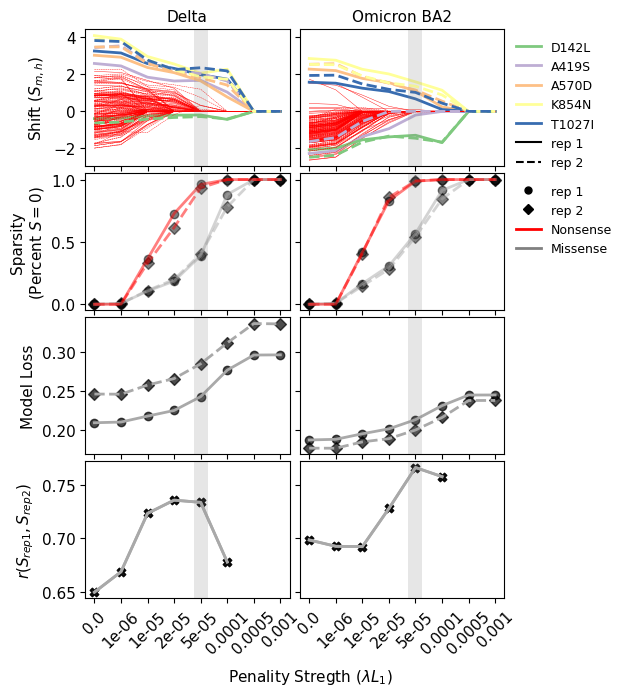

In [196]:
saveas="shrinkage_analysis_trace_plots"
fig, ax = plt.subplots(4,2, figsize=[6.4,7],sharex=True, sharey='row')

lasso_cmap=plt.get_cmap("Set2").colors
lasso_shrinkage = sorted(models.λ_lasso_shift.unique())
lasso_shrinkage_cmap = dict(zip(lasso_shrinkage, lasso_cmap))

mutations_to_highlight = ["D142L", "A419S", "A570D", "K854N", "T1027I"]
mutations_cmap=plt.get_cmap("Accent").colors
mutations_cmap = dict(zip(mutations_to_highlight, mutations_cmap))

condition_col = {
    "Delta" : 0,
    "Omicron_BA2" : 1
}

replicate_line_style = {
    0 : "-",
    1 : "--"
}

replicate_marker = {
    0 : "o",
    1 : "D"
}

sense_colors = {
    "Missense" : "darkgrey",
    "Nonsense" : "red"
}

sense_lw = {
    "Missense" : 0.5,
    "Nonsense" : 0.3
}

sense_alpha = {
    "Missense" : 0.1,
    "Nonsense" : 1.0
}

model_choice = 5e-5
model_line_kwargs = {
    "linewidth" : 10,
    "color" : "grey",
    "alpha" : 0.1
}

for (condition, replicate), df in tall_mut_df.groupby(["condition", "replicate"]):
    row = 0
    iter_ax = ax[row, condition_col[condition]]
    
#     # plot missense, non validated
#     for mut, trace_df in df.query(
#         "sense == 'Missense' & not mutation.isin(@mutations_to_highlight)"
#     ).groupby("mutation"):
#         iter_ax.plot(
#             trace_df.λ_lasso, 
#             trace_df.S,
#             linestyle=replicate_line_style[replicate],
#             linewidth=sense_alpha['Missense'],
#             alpha=sense_alpha['Missense'],
#             color="lightgrey"
#         )
    
    # plot stop traces
    for mut, trace_df in df.query("sense == 'Nonsense'").groupby("mutation"):

        iter_ax.plot(
            trace_df.λ_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=sense_lw['Nonsense'],
            alpha=sense_alpha['Nonsense'],
            color=sense_colors['Nonsense']
        )

    # plot highlighted muts
    for mut, trace_df in df.query(
        "mutation.isin(@mutations_to_highlight)"
    ).groupby("mutation"):
        iter_ax.plot(
            trace_df.λ_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=2,
            alpha=1.0,
            color=mutations_cmap[mut]
        )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
    
        
    # Plot sparsity    
    row = 1
    iter_ax = ax[row, condition_col[condition]]
    for sense in ["Missense", "Nonsense"]:
        iter_ax.plot(
            lasso_sparsity_loss["lasso"],
            lasso_sparsity_loss[f"{condition}-{replicate}-{sense}-sparsity"],
            linestyle=replicate_line_style[replicate],
            linewidth=2,
            alpha=0.5,
            color=sense_colors[sense]
        )
        
        iter_ax.scatter(
            lasso_sparsity_loss["lasso"],
            lasso_sparsity_loss[f"{condition}-{replicate}-{sense}-sparsity"],
            marker=replicate_marker[replicate],
            alpha=0.5,
            color="black"
        )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
        
    # Plot Loss  
    row = 2
    iter_ax = ax[row, condition_col[condition]]
    
    iter_ax.plot(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-{replicate}-loss"],
        linestyle=replicate_line_style[replicate],
        linewidth=2,
        alpha=1.0,
        color="darkgrey"
    )

    iter_ax.scatter(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-{replicate}-loss"],
        marker=replicate_marker[replicate],
        alpha=0.7,
        color="black"
    )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
    
    # Plot Correlation  
    row = 3
    iter_ax = ax[row, condition_col[condition]]
    
    iter_ax.plot(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-replicate-correlation"],
        linestyle="-",
        linewidth=2,
        alpha=1.0,
        color="darkgrey"
    )
    
    iter_ax.scatter(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-replicate-correlation"],
        marker="X",
        alpha=0.7,
        color="black"
    )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)

    
# TODO labels
# fig.suptitle("Shrinkage Analysis", size=13)

ax[0, 0].set_title("Delta", size=11)
ax[0, 1].set_title("Omicron BA2", size=11)

ax[0, 0].set_ylabel("Shift $(S_{m,h})$", size=11)
ax[1, 0].set_ylabel("Sparsity\n(Percent $S = 0$)", size=11)
ax[2, 0].set_ylabel("Model Loss", size=11)
ax[3, 0].set_ylabel("$r(S_{rep1},S_{rep2})$", size=11)


# TODO legends
black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
lasso_color_handles = [
    mlines.Line2D(
        [], [], 
        color=color, 
        linestyle='-',
        markersize=2,
        linewidth=2,
        label=mut
    )
    for mut, color in mutations_cmap.items()
]

elements = lasso_color_handles + [black_line, black_dashed] 
ax[0,1].legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)

black_circle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=5, label='rep 1')
black_triangle = mlines.Line2D([], [], color='black', marker='D', linestyle='None',
                          markersize=5, label='rep 2')
# lasso_color_handles = [
#     mlines.Line2D(
#         [], [], 
#         color=color, 
#         linestyle='-',
#         markersize=10,
#         label=f"λ = {lasso}"
#     )
#     for lasso, color in lasso_shrinkage_cmap.items()
# ]
red_line = mlines.Line2D([], [], color='red', linewidth=2,linestyle='-',markersize=5, label='Nonsense')
grey_line = mlines.Line2D([], [], color='grey',linewidth=2, linestyle='-',markersize=5, label='Missense')

elements = [black_circle, black_triangle, red_line, grey_line] #+lasso_color_handles
ax[1, 1].legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)

ax[3,0].set_xticks(ax[3,0].get_xticks(), ax[3,0].get_xticklabels(), rotation=45, ha='center')
ax[3,1].set_xticks(ax[3,1].get_xticks(), ax[3,1].get_xticklabels(), rotation=45, ha='center')

ax[3,0].set_xlabel(f"Penality Stregth ($\lambda L_{1}$)")
ax[3,0].xaxis.set_label_coords(1.1, -.5)

plt.tight_layout()
fig.subplots_adjust(hspace=0.05, wspace=0.05)
fig.savefig(f"{OUTDIR}/{saveas}.pdf")
fig.savefig(f"{OUTDIR}/{saveas}.png")
# plt.tight_layout()
plt.show()

## Global Epistasis Fits

## Percent Shifts Under X

## Correlation of BA2 and Delta Shifts

## Sitewise Sum of Shifts by Site

## Comparison to Naive approach

## Betas and Shifts (Distributions and Correlations)

## Shifted Mutations, Heat and Sitemap

## Validation Mutations Shift V Titer fold change